# SSD Evaluation Tutorial

This is a brief tutorial that explains how compute the average precisions for any trained SSD model using the `Evaluator` class. The `Evaluator` computes the average precisions according to the Pascal VOC pre-2010 or post-2010 detection evaluation algorithms. You can find details about these computation methods [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#sec:ap).

As an example we'll evaluate an SSD300 on the Pascal VOC 2007 `test` dataset, but note that the `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the evaluation on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

Note: I that in case you would like to evaluate a model on MS COCO, I would recommend to follow the [MS COCO evaluation notebook](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_evaluation_COCO.ipynb) instead, because it can produce the results format required by the MS COCO evaluation server and uses the official MS COCO evaluation code, which computes the mAP slightly differently from the Pascal VOC method.

Note: In case you want to evaluate any of the provided trained models, make sure that you build the respective model with the correct set of scaling factors to reproduce the official results. The models that were trained on MS COCO and fine-tuned on Pascal VOC require the MS COCO scaling factors, not the Pascal VOC scaling factors.

In [2]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

import os
import os.path as p

Using TensorFlow backend.


In [3]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 20
model_mode = 'training'

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

weights_path = '/usr/local/data/msmith/uncertainty/ssd_keras/good_dropout_model/ssd300_dropout_PASCAL2012_train_+12_epoch-58_loss-3.8960_val_loss-5.0832.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

W1121 16:15:06.265161 140201693157120 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1121 16:15:06.267094 140201693157120 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1121 16:15:06.297540 140201693157120 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1121 16:15:06.299231 140201693157120 deprecation_wrapper.py:119] From /home/vision/msmith/localDrive/msmith/anaconda3/lib/python

Or

### 1.2. Load a trained model

We set `model_mode` to 'inference' above, so the evaluator expects that you load a model that was built in 'inference' mode. If you're loading a model that was built in 'training' mode, change the `model_mode` parameter accordingly.

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd300_dropout_pascal_07+12_epoch-114_loss-4.3685_val_loss-4.5034.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

In [ ]:
model.summary()

## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [5]:
ROOT_PATH = '/usr/local/data/msmith/APL/Datasets/PASCAL/'
# The directories that contain the images.
VOC_2007_images_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2007/JPEGImages/')
VOC_2012_images_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2012/JPEGImages/')

# The directories that contain the annotations.
VOC_2007_annotations_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2007/Annotations/')
VOC_2012_annotations_dir      = p.join(ROOT_PATH,'VOCdevkit/VOC2012/Annotations/')

# The paths to the image sets.
VOC_2007_train_image_set_filename    = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/train.txt')
VOC_2012_train_image_set_filename    = p.join(ROOT_PATH,'VOCdevkit/VOC2012/ImageSets/Main/train.txt')
VOC_2007_val_image_set_filename      = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/val.txt')
VOC_2012_val_image_set_filename      = p.join(ROOT_PATH,'VOCdevkit/VOC2012/ImageSets/Main/val.txt')
VOC_2007_trainval_image_set_filename = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/trainval.txt')
VOC_2012_trainval_image_set_filename = p.join(ROOT_PATH,'VOCdevkit/VOC2012/ImageSets/Main/trainval.txt')
VOC_2007_test_image_set_filename     = p.join(ROOT_PATH,'VOCdevkit/VOC2007/ImageSets/Main/test.txt')

dataset = DataGenerator(load_images_into_memory=True)


# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

dataset.parse_xml(images_dirs=[VOC_2012_images_dir],
                  image_set_filenames=[VOC_2012_val_image_set_filename],
                  annotations_dirs=[VOC_2012_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Loading images into memory: 100%|██████████| 5823/5823 [01:06<00:00, 87.20it/s] 


## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [6]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=2,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 5823

Producing predictions batch-wise: 100%|██████████| 2912/2912 [02:39<00:00, 11.19it/s]
Matching predictions to ground truth, class 1/20.: 100%|██████████| 9115/9115 [00:00<00:00, 21509.26it/s]
Matching predictions to ground truth, class 2/20.: 100%|██████████| 4937/4937 [00:00<00:00, 28537.91it/s]
Matching predictions to ground truth, class 3/20.: 100%|██████████| 24373/24373 [00:00<00:00, 32677.22it/s]
Matching predictions to ground truth, class 4/20.: 100%|██████████| 20421/20421 [00:00<00:00, 23329.56it/s]
Matching predictions to ground truth, class 5/20.: 100%|██████████| 37001/37001 [00:00<00:00, 39748.54it/s]
Matching predictions to ground truth, class 6/20.: 100%|██████████| 3867/3867 [00:00<00:00, 21291.08it/s]
Matching predictions to ground truth, class 7/20.: 100%|██████████| 38953/38953 [00:01<00:00, 24611.19it/s]
Matching predictions to ground truth, class 8/20.: 100%|██████████| 5130/5130 [00:00<00:00, 23991.56it/s]
Matching

## 4. Visualize the results

Let's take a look:

In [7]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

aeroplane     AP    0.791
bicycle       AP    0.766
bird          AP    0.671
boat          AP    0.529
bottle        AP    0.4
bus           AP    0.794
car           AP    0.701
cat           AP    0.839
chair         AP    0.487
cow           AP    0.673
diningtable   AP    0.594
dog           AP    0.811
horse         AP    0.758
motorbike     AP    0.801
person        AP    0.747
pottedplant   AP    0.4
sheep         AP    0.7
sofa          AP    0.65
train         AP    0.797
tvmonitor     AP    0.674

              mAP   0.679


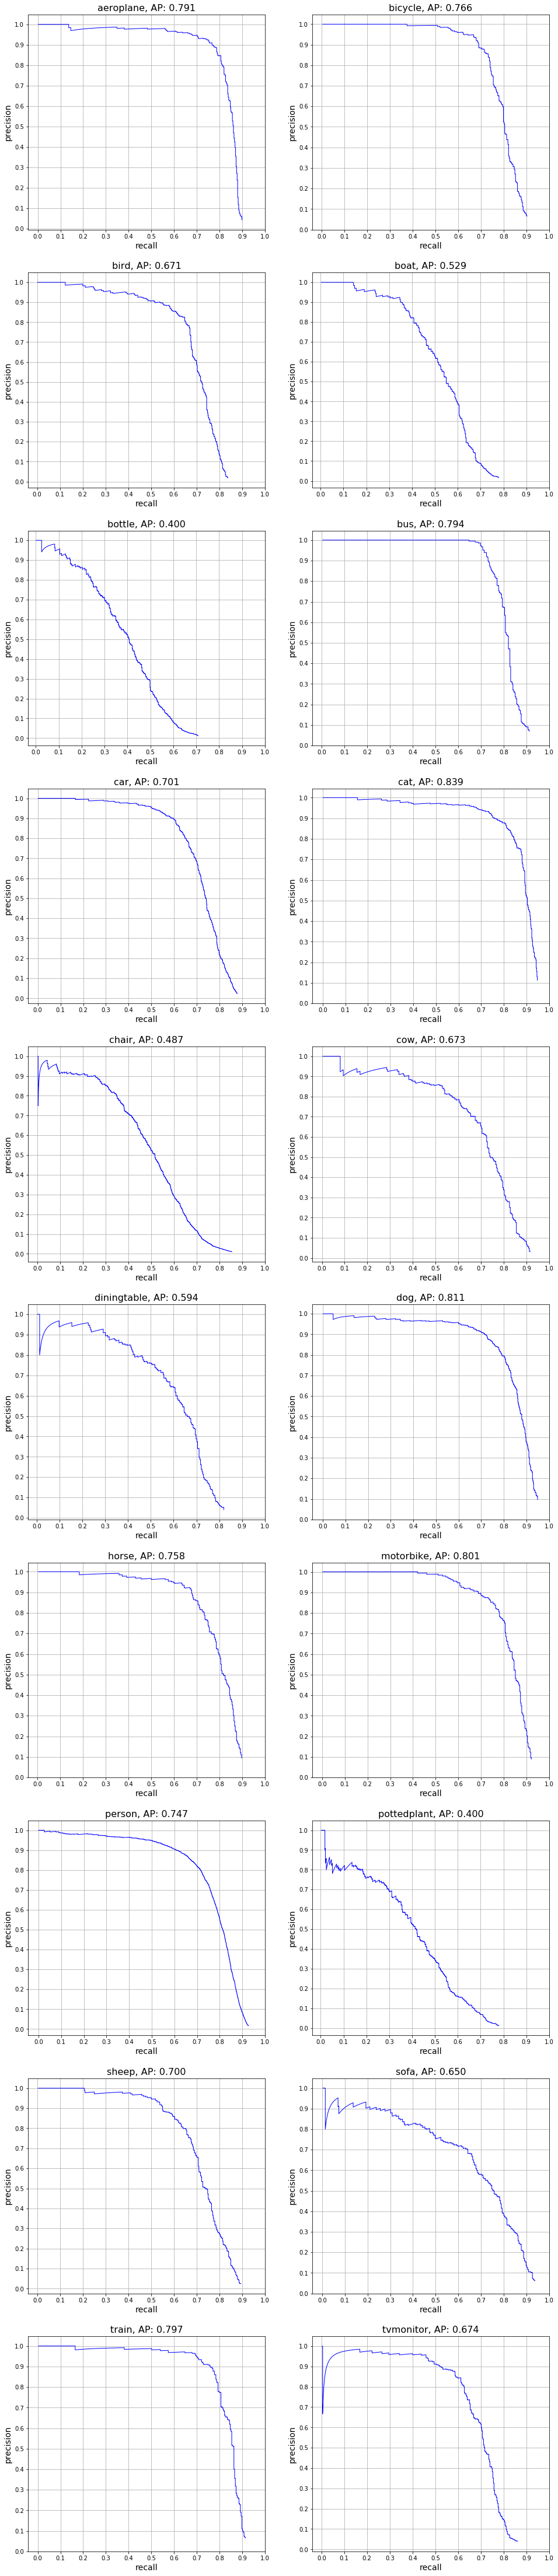

In [8]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [ ]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

In [ ]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))